In [1]:
%env THEANO_FLAGS=device=gpu0
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

env: THEANO_FLAGS=device=gpu0


In [2]:
from utils.southpark import get_conversations
conversations = get_conversations("/srv/hd7/jheuristic/cartman/sp.json")
    
from utils.preprocessor import Preprocessor

preproc = Preprocessor.from_conversations(conversations,verbose=True)


100%|██████████| 7285/7285 [00:03<00:00, 2013.68it/s]


23281 out of 23281 tokens, coverage=1.00000)


# model

In [3]:
from models.twoline_smooth_ce import ConversationModelSCE
model = ConversationModelSCE(preproc,bottleneck_size=512)

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:228: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <unspecified>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps or "<unspecified>"))
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:446: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_sc

In [4]:
import numpy as np
model.temperature.set_value(np.logspace(0,1,base=np.e,num=10).astype('float32'))

# training

In [5]:
max_len=10
batch_size=100
n_epochs=100

In [6]:
from utils.generate import get_phrase_pairs,iterate_minibatches

convs_ix = list(preproc.preprocess_conversations(conversations,verbose=True,max_len=max_len))

prev_phrases,reference_answers = get_phrase_pairs(convs_ix,
                                                  speaker_filter = lambda s1,s2: 'cartman' in s2).swapaxes(0,1).astype('int32')




100%|██████████| 7285/7285 [00:04<00:00, 1778.20it/s]


In [ ]:
epoch_counter = 1
ce = []

25 iterations...
50 iterations...
75 iterations...
beginning new loop...


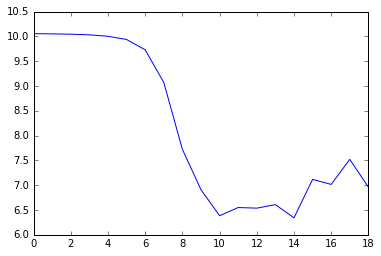

A: i'llba poppa yourba bitcha assa tooba , bitcha .
B: 
B true: what the hell is goin' on in this cartoon
100 iterations...
125 iterations...
150 iterations...
175 iterations...
beginning new loop...


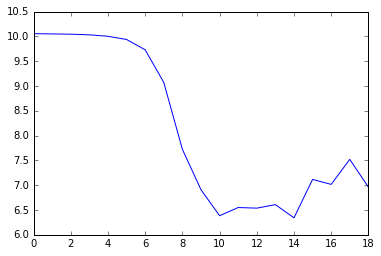

A: okay , children . each of you gets to
B: 
B true: reading sucks ass .
200 iterations...
225 iterations...
250 iterations...
beginning new loop...


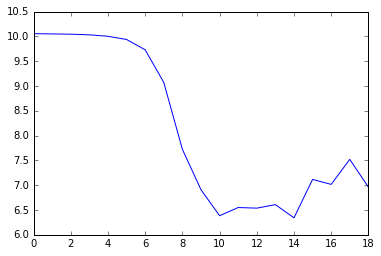

A: no - o !
B: 
B true: why the hell does the fbi keep arresting all
275 iterations...
300 iterations...
325 iterations...
350 iterations...
beginning new loop...


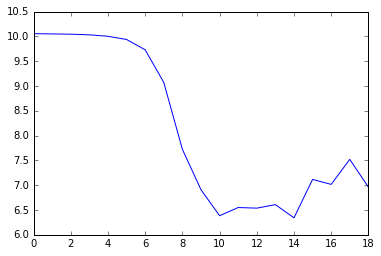

A: yeah , but you know ? i think we
B: 
B true: boy , i say .
375 iterations...
400 iterations...
425 iterations...
450 iterations...
beginning new loop...


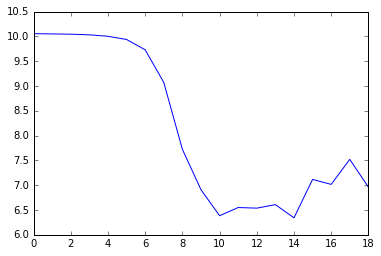

A: mememe ! i'm first ! i'm first !
B: 
B true: choo - choo train ! yay !
475 iterations...
500 iterations...
525 iterations...
beginning new loop...


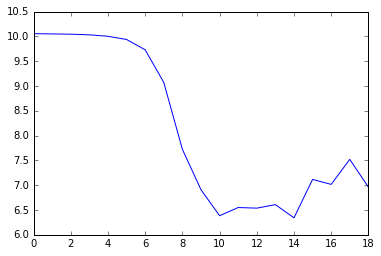

A: i'll thell them . . . to call you
B: 
B true: it's an emergency ! it's an emergency !
550 iterations...
575 iterations...
600 iterations...
625 iterations...
beginning new loop...


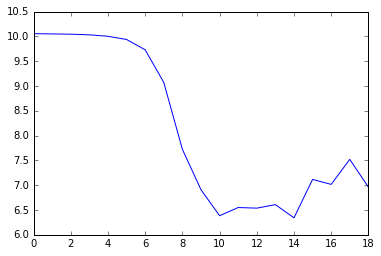

A: why would they play such a cruel joke on
B: 
B true: egh , because they're poor , kyle ! poor
650 iterations...
675 iterations...
700 iterations...
beginning new loop...


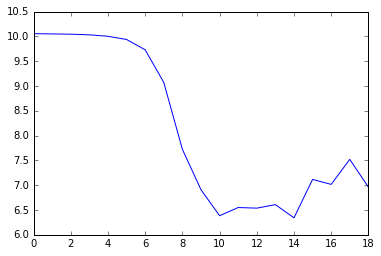

A: oh god !
B: 
B true: we only have until 10 a . m .
725 iterations...
750 iterations...
775 iterations...
800 iterations...
beginning new loop...


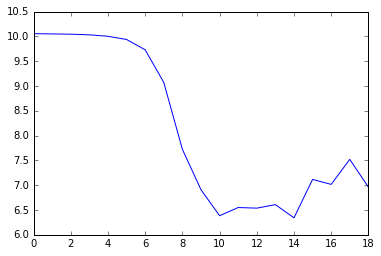

A: suction !
B: 
B true: hey , who's screwing with the lights ?
825 iterations...
850 iterations...
875 iterations...
900 iterations...
beginning new loop...


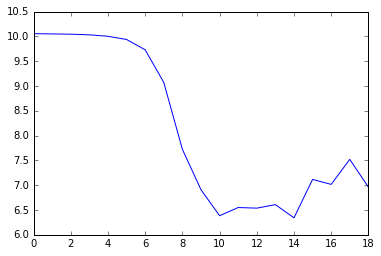

A: oh , eric . i'm very proud of you
B: 
B true: tha . . . thank you ?
925 iterations...


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(n_epochs):
    for b_x,b_y in iterate_minibatches([prev_phrases,reference_answers],batch_size,shuffle=True):
        ce.append(model.train_fun(b_x,b_y))
        
        epoch_counter +=1
        
        if epoch_counter %25==0:
            print epoch_counter,'iterations...'
    print "beginning new loop..."
    plt.plot(ce)
    plt.show()
    
    ph =preproc.ix_to_phrase(b_x[0])
    print 'A:', ph
    print 'B:', model.reply(ph)
    print 'B true:',preproc.ix_to_phrase(b_y[0])
        

In [ ]:
ce